# MeOH synthesis model comparison (Grabow vs RMG)

Source for grabow model:  
Grabow, L. C., & Mavrikakis, M. (2011). Mechanism of methanol synthesis on cu through CO2 and CO hydrogenation. ACS Catalysis, 1(4), 365–384. https://doi.org/10.1021/cs200055d

In [23]:
import pandas as pd
import numpy as np
import time
import cantera as ct
from matplotlib import pyplot as plt
import csv
import math
import os
import sys
from IPython.display import Image

import itertools
import logging
from collections import defaultdict

import scipy.linalg as la

print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.4.0


## Experimental Conditions for Graaf spinning basket reactor study.

Graaf, G. H., Stamhuis, E. J., & Beenackers, A. A. C. M. (1988). Kinetics of low-pressure methanol synthesis. Chemical Engineering Science, 43(12), 3185–3195. https://doi.org/10.1016/0009-2509(88)85127-3


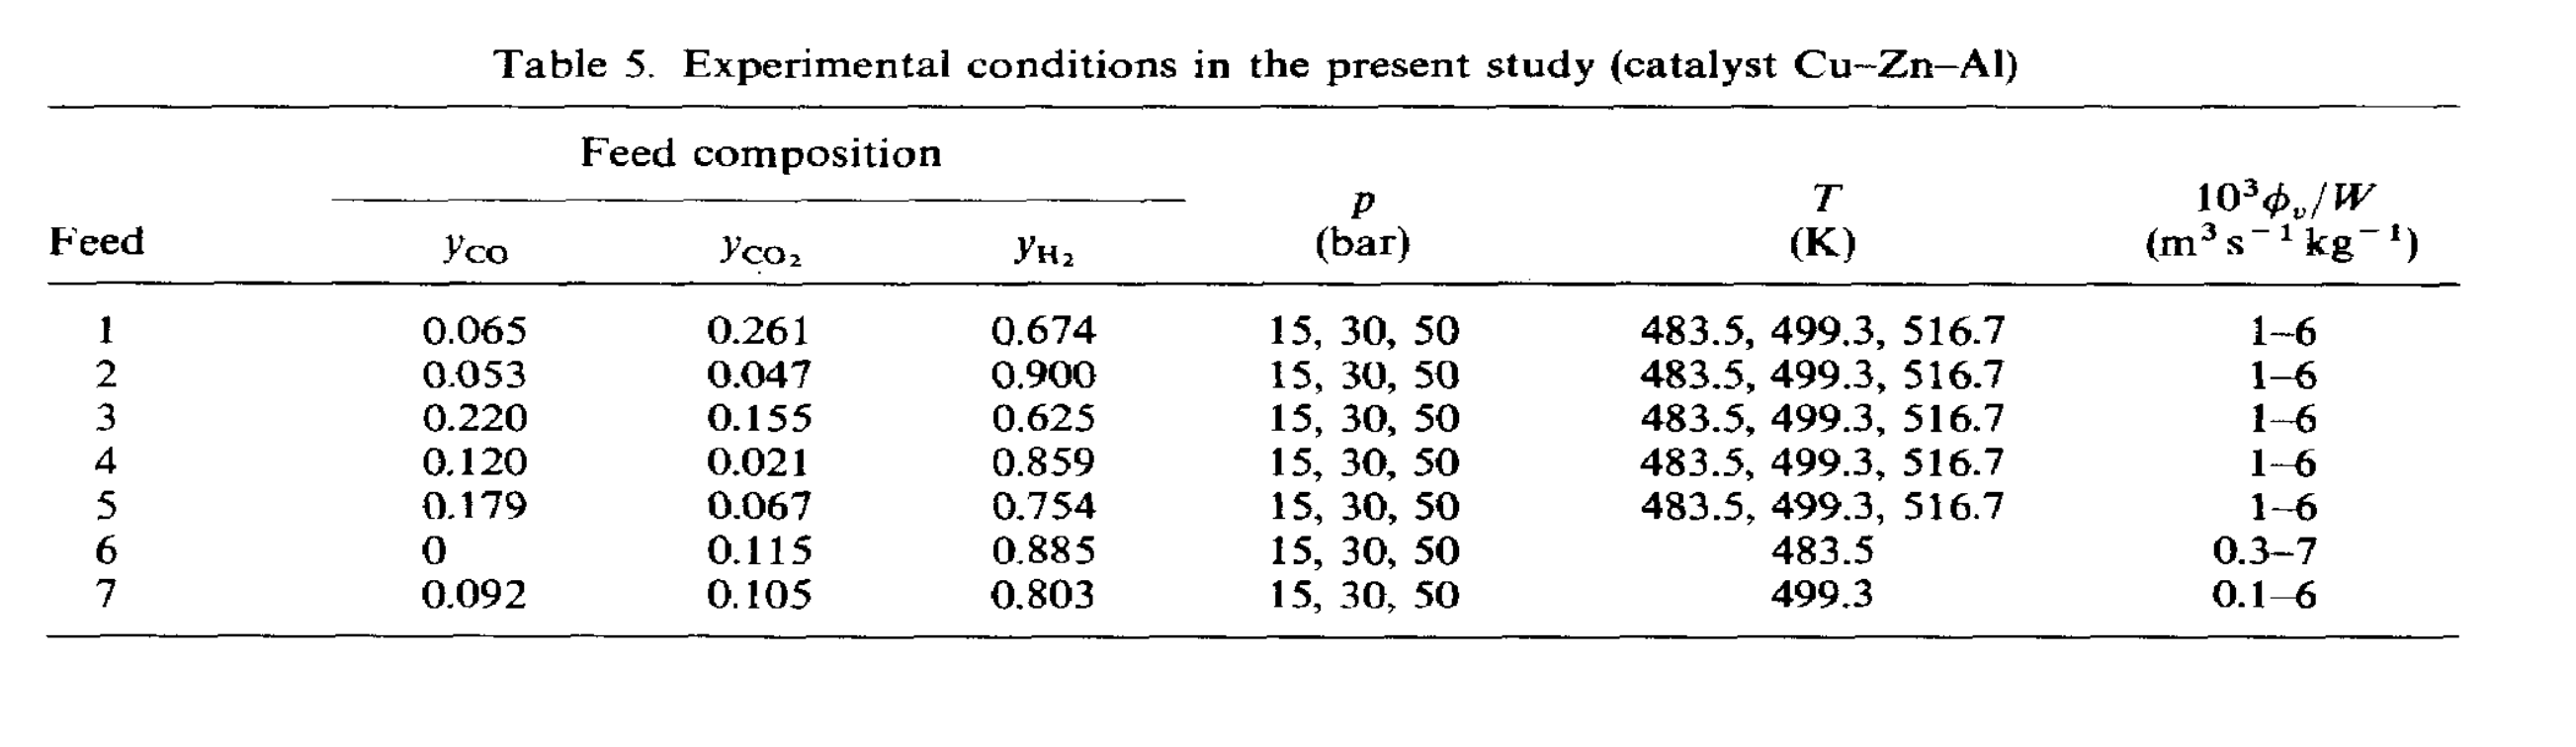

In [54]:

Image(filename='../images/Graaf_Experimental_Conditions.png',width = 700, height = 300) 

## Experimental Conditions for Graaf spinning basket reactor study (PhD thesis).

Graaf, Geert. (2016). The Synthesis of methanol in Gas-Solid and Gas-Slurry Reactors - PhD Thesis, 1988. 10.13140/RG.2.1.1002.8402. 


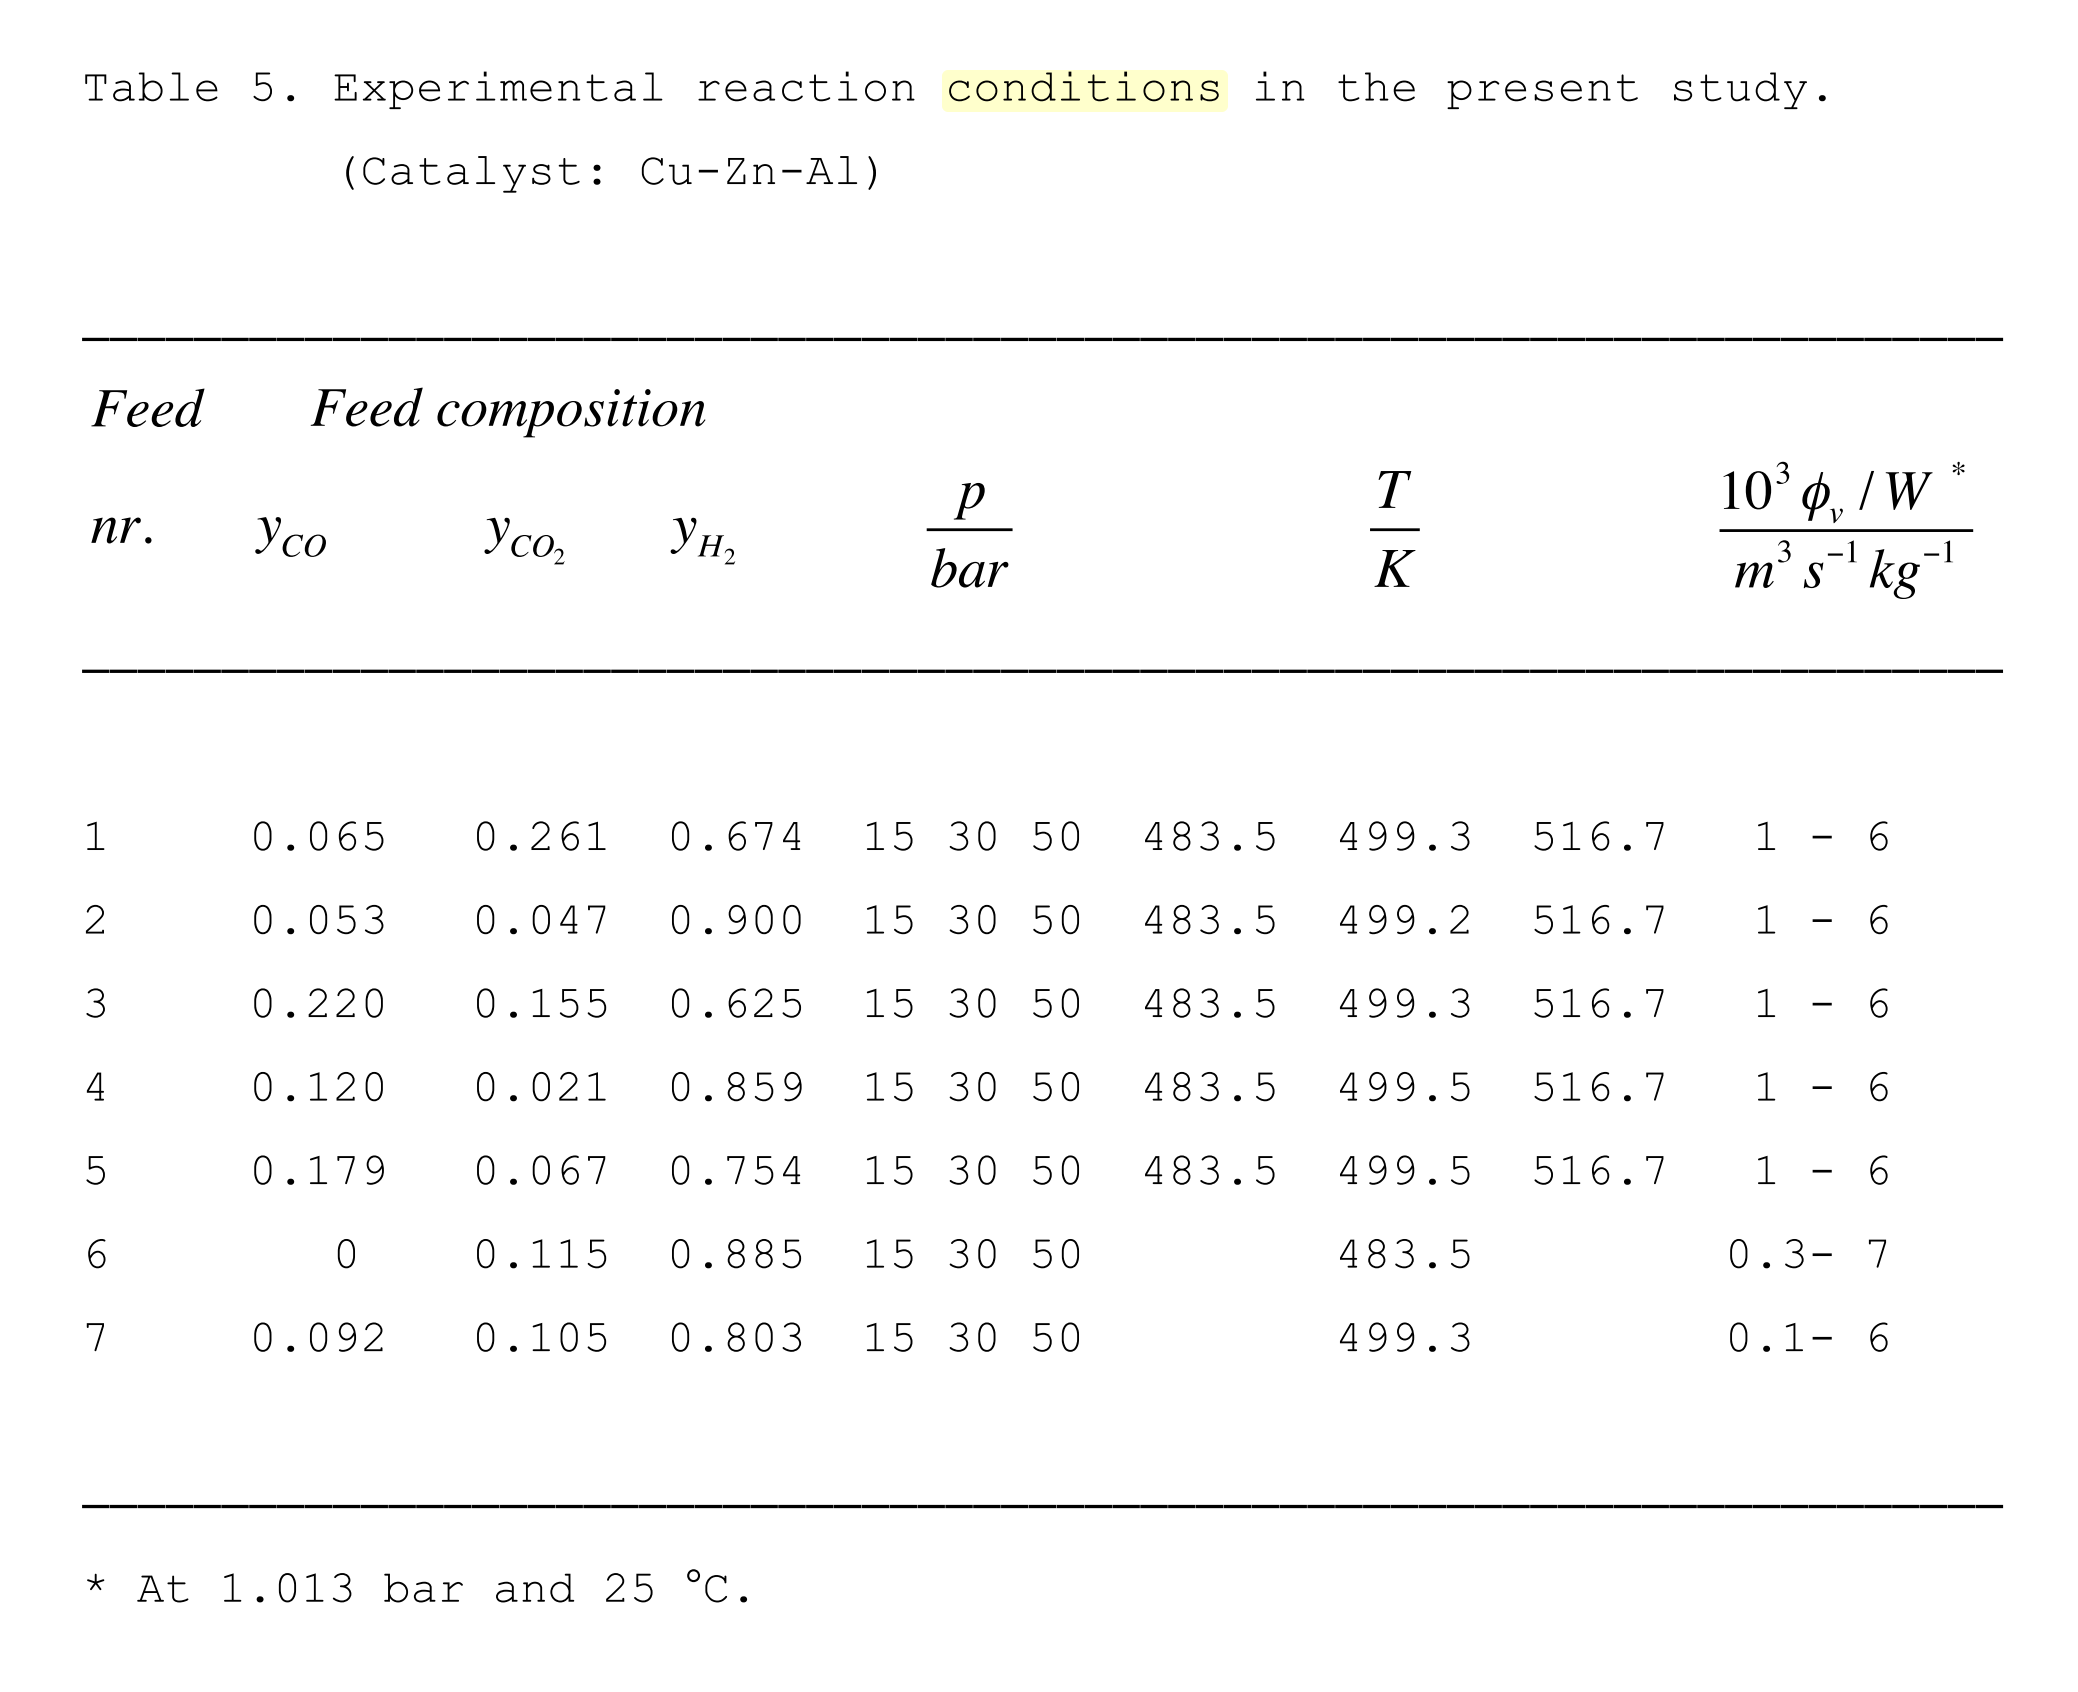

In [55]:

Image(filename='../images/Graaf_PhD_Experimental_Conditions.png',width = 600, height = 300) 

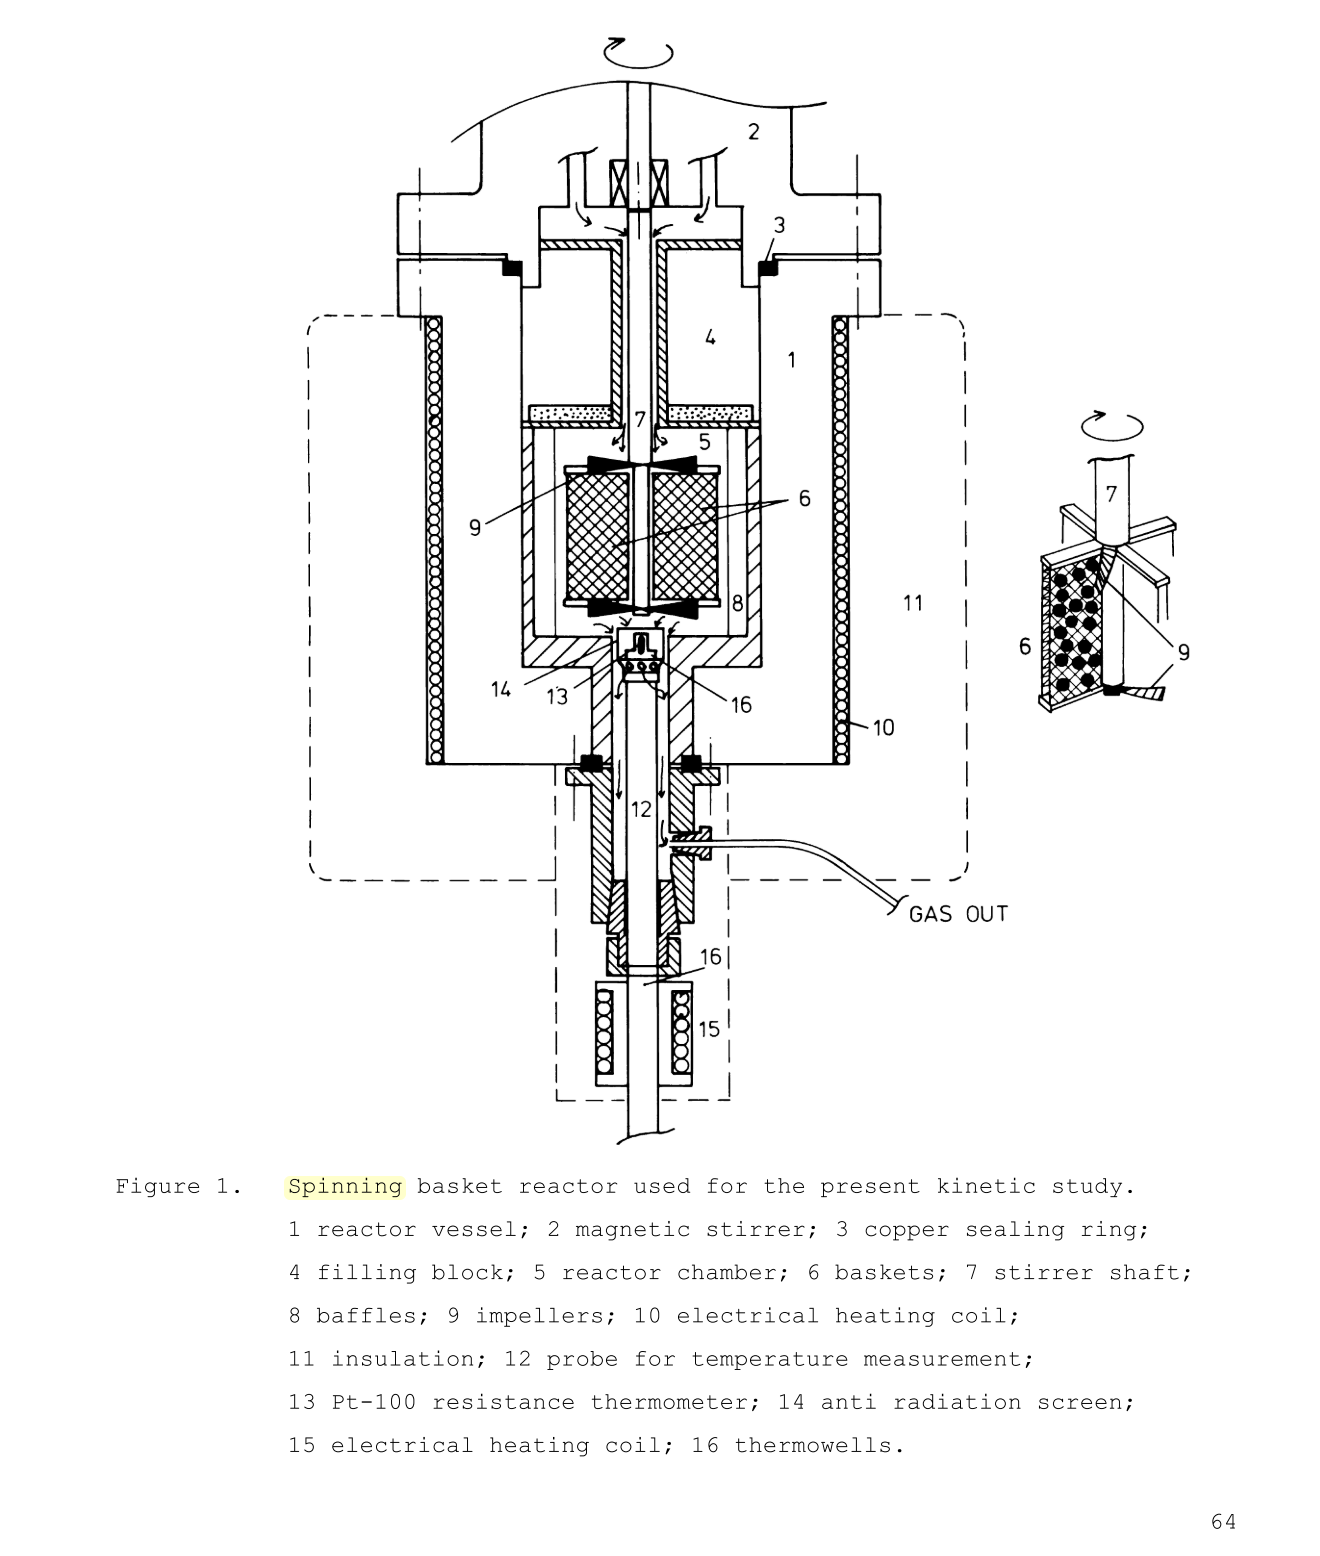

In [56]:
Image(filename='../images/spinning_basket_reactor_Graff.png')

## Graaf reactor specifications
pp 260-269: 2 Phase reactor Conditions
catalyst weights used: 4.24, 1.36, 7.97, 1.53 g catalyst used for their experiments

$\frac{10^{3}\phi_v}{W}$ volume flow rate at T=298.15K, P = 1.013 bar. per kg catalyst

pp 63 ID of reactor and height are 70mm each 

## Industrial conditions
temp =  230-280C.  
pressure = 50-120 atm.   
CO/CO2/H2 = 10/10/80.    

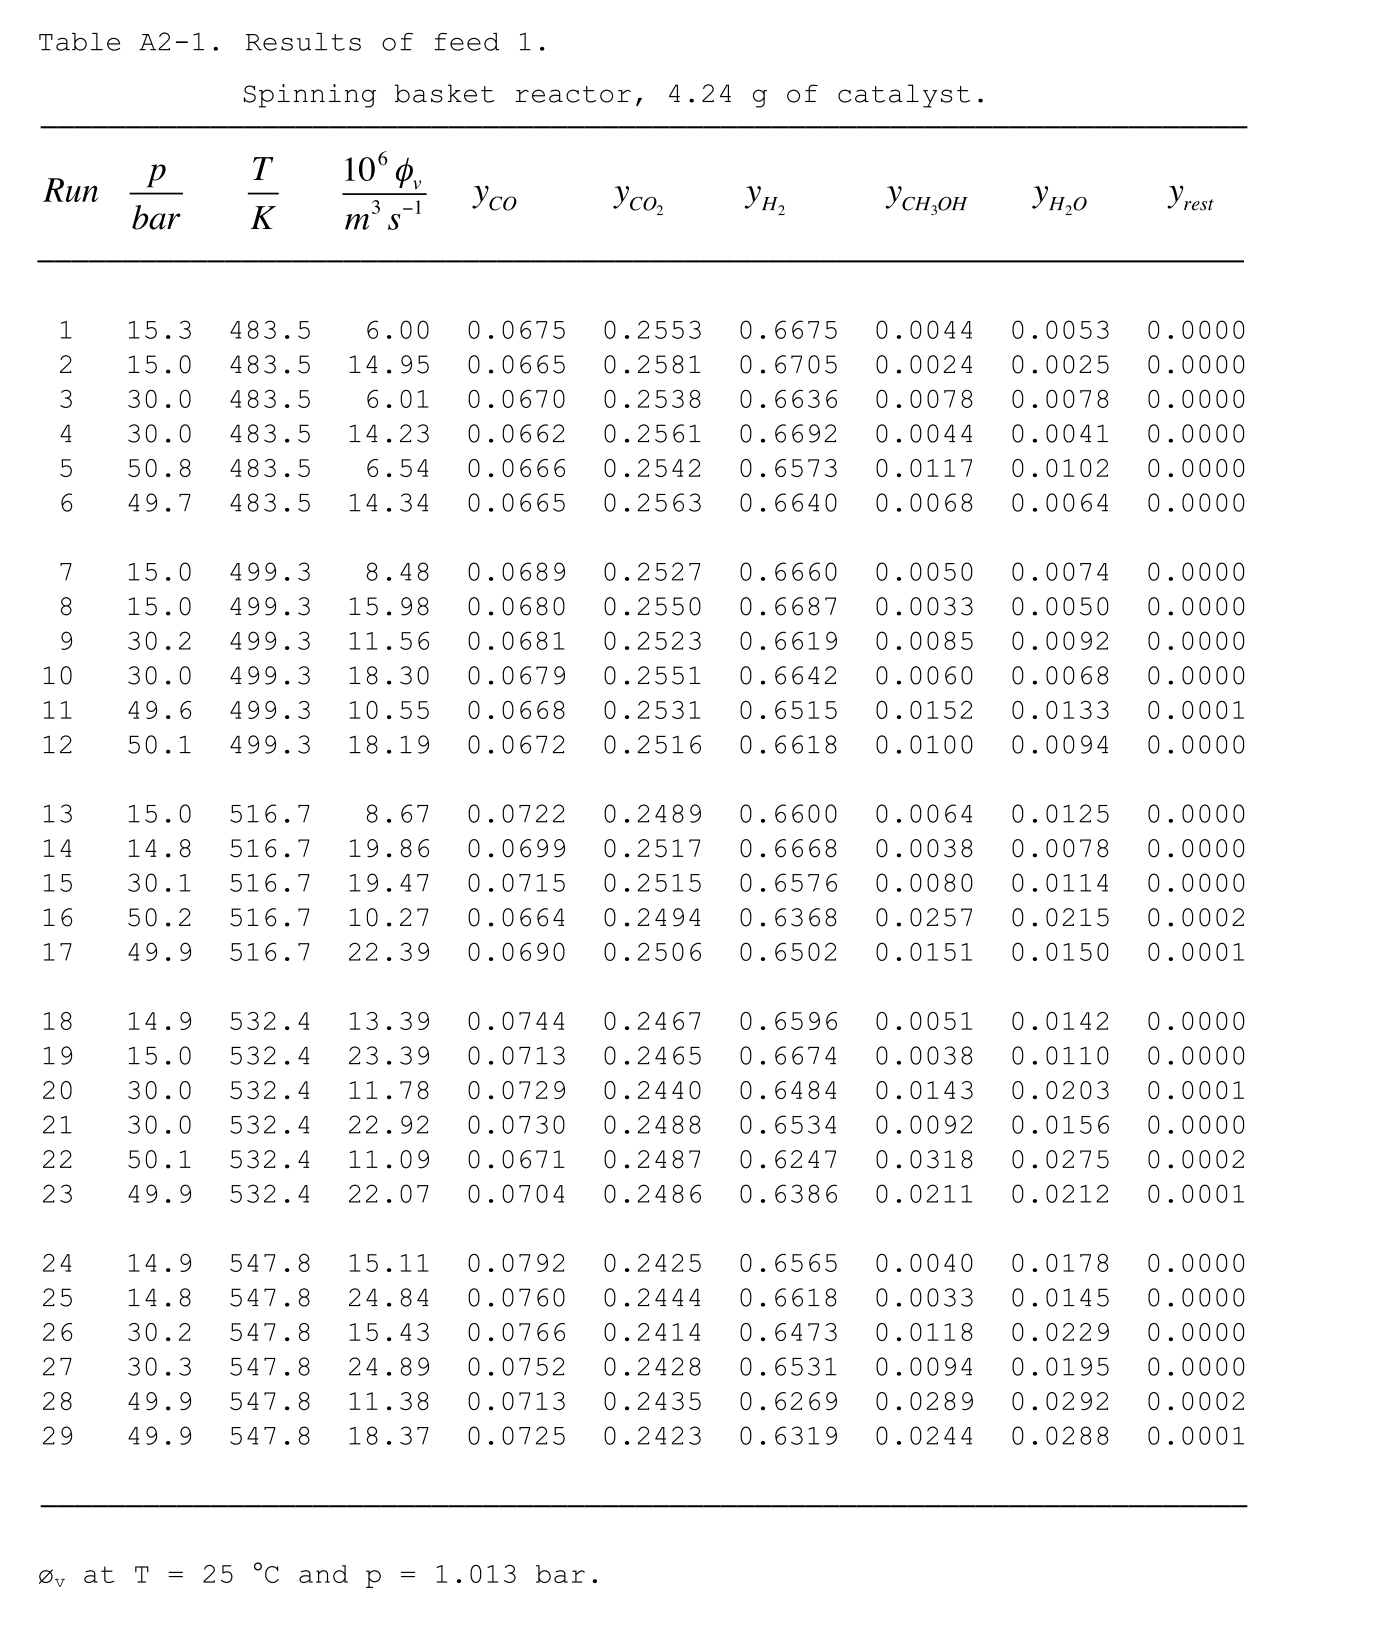

In [57]:
Image(filename='../images/Graaf_Feed_1.png',width = 600, height = 300) 

In [44]:
os.remove("Results_single.csv") 
# Grabow model and RMG input files
# cti_file_rmg = 'Grabow_species_removed/chem_annotated_removed.cti'
cti_file_rmg = 'chem_annotated.cti'

# Multipliers
cat_mult = 100

#constants
pi = math.pi

# set initial temps, pressures, concentrations
# temp = 230+273.15         # [kelvin]
temp = 528# 483.5                # [kelvin]
pressure = 15.3*1e5         # [Pascals] 
X_co = 0.025
X_co2= 0.025
X_h2 = 0.95
mw_co = 28.01e-3     # [kg/mol]
mw_co2 = 44.01e-3    # [kg/mol]
mw_h2 = 1.01e-3      # [kg/mol]

# CO/CO2/H2/H2O: typical is 
concentrations_rmg = {'CO(3)': X_co,'CO2(4)': X_co2, 'H2(2)':X_h2}

# initialize cantera gas and surface
gas= ct.Solution(cti_file_rmg,'gas')

# surf_grab = ct.Interface(cti_file,'surface1_grab', [gas_grab])
surf = ct.Interface(cti_file_rmg,'surface1', [gas])

# gas_grab.TPX = 
gas.TPX = temp, pressure, concentrations_rmg
surf.TP = temp, pressure
surf.coverages = 'X(1):1.0'

# create gas inlet
inlet = ct.Reservoir(gas)

#create gas outlet
exhaust = ct.Reservoir(gas)

# Reactor volume
rradius = 35e-3
rlength = 70e-3
rvol = (rradius**2)*pi*rlength

# Catalyst Surface Area
site_density = surf.site_density*1000                #[mol/m^2]cantera uses kmol/m^2, convert to mol/m^2
cat_weight = 4.24e-3                                 #[kg]
cat_site_per_wt = (300*1e-6)*1000                    #[mol/kg] 1e-6mol/micromole, 1000g/kg
cat_area = cat_mult*site_density/(cat_weight*cat_site_per_wt) #[m^3]

# reactor initialization
r = ct.IdealGasConstPressureReactor(gas, energy='off')
# r = ct.IdealGasReactor(gas, energy='off')
rsurf = ct.ReactorSurface(surf, r, A=cat_area)
r.volume = rvol

# flow controllers (Graaf measured flow at 293.15 and 1 atm)
one_atm = ct.one_atm
FC_temp = 293.15
volume_flow = 4.24e-3                                               # [m^3/s]
molar_flow = volume_flow*one_atm/(8.3145*FC_temp)                     # [mol/s]
mass_flow = molar_flow*(X_co*mw_co+X_co2*mw_co2) # [kg/s]
mfc = ct.MassFlowController(inlet, r, mdot=mass_flow)

# initialize reactor network
sim = ct.ReactorNet([r])
# set relative and absolute tolerances on the simulation
sim.rtol = 1.0e-11
sim.atol = 1.0e-22

#for debugging
sim.verbose = True
sim.reinitialize()


print(cat_area)

Initializing reactor network.
Reactor 0: 31 variables.
              0 sensitivity params.
Number of equations: 31
Maximum time step:                0
2.1383647798742142


In [38]:
gas.density

1.2949447896334747

In [18]:
# for i in range(0, surf.n_reactions):
#      if 'C2HOX(465)' in str(surf.reaction_equation(i)):
#         print(surf.reaction_equation(i), i)
# #         surf.set_multiplier(0.1,i)
        
# for i in range(0, surf.n_reactions):
#      if 'H2X(50)' in str(surf.reaction_equation(i)):
#         print(surf.reaction_equation(i), i)
#         surf.set_multiplier(0.0,i)
        


H2(2) + X(1) <=> H2X(50) 66
H2X(50) + X(1) <=> 2 H*(10) 67
H2X(50) + O*(11) <=> H*(10) + OH*(12) 68
CO*(14) + H2X(50) <=> H*(10) + HCO*(16) 69
CO2*(15) + H2X(50) <=> H*(10) + HCOO*(17) 70
CO2*(15) + H2X(50) <=> COOH*(18) + H*(10) 71
CH2O*(19) + H2X(50) <=> CH3O*(20) + H*(10) 72
CH2O*(19) + H2X(50) <=> CH3OX(46) + H*(10) 93
COX(60) + H2X(50) <=> CHOX2(61) + H*(10) 102
CHOX2(61) + H2X(50) <=> CH2OX2(52) + H*(10) 127
H2X(50) + SX(541) <=> H*(10) + SX(559) 156
C2HOX(557) + H2X(50) <=> H*(10) + SX(541) 178
CH2OX(176) + H2X(50) <=> CH3OX(46) + H*(10) 231
CHOX(175) + H2X(50) <=> CH2OX(176) + H*(10) 252
CHX(32) + H2X(50) <=> CH2X(63) + H*(10) 270
CH2X(63) + H2X(50) <=> CH3X(55) + H*(10) 310


## Grabow Values Given

300 $\mu$mol(sites)/g(catalyst).

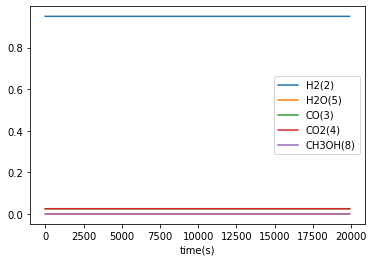

In [45]:
output_filename = f'Results_single.csv'
outfile = open(output_filename,'w')
writer = csv.writer(outfile)
writer.writerow(['time(s)','T (C)', 'P (atm)', 'gas density'] 
                + gas.species_names + surf.species_names,)

t = 0.0
dt = 0.1

# Setup solution array"
states = ct.SolutionArray(gas, extra=['t'])

while t < 20000.0:
    t += dt
    sim.advance(t)
    writer.writerow([t,temp, pressure, gas.density] +
                 list(gas.X) + list(surf.X),)
        
results = pd.read_csv('Results_single.csv')
results.plot('time(s)',['H2(2)', 'H2O(5)', 'CO(3)','CO2(4)','CH3OH(8)'])


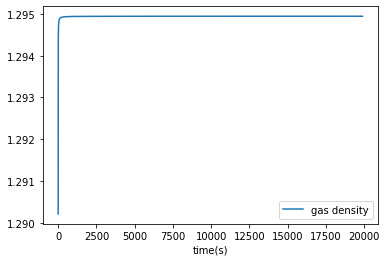

In [46]:
results.plot('time(s)',['gas density'])

In [25]:
sim.advance_to_steady_state(max_steps=100000,residual_threshold=sim.rtol*2,return_residuals=True)
writer.writerow([temp, pressure, 'V (M^3/s)', 'X_co initial','X_co initial','X_co initial', gas.T] +
                 list(gas.X) + list(surf.X),)


***********************************************************************
CanteraError thrown by Phase::setDensity():
density must be positive. density = -13.9175
***********************************************************************

***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[2] = inf
ydot[3] = inf
ydot[4] = -nan
ydot[5] = -nan
ydot[6] = -nan
ydot[7] = -nan
ydot[8] = -nan
ydot[9] = -nan
ydot[10] = -nan
ydot[11] = -nan
ydot[12] = -nan
ydot[13] = -nan
ydot[14] = -nan
ydot[15] = -nan
ydot[16] = -nan
ydot[17] = -inf
ydot[18] = inf
ydot[19] = -nan
ydot[20] = inf
ydot[22] = -nan
ydot[23] = -inf
ydot[25] = -nan
ydot[26] = inf
ydot[27] = -nan
ydot[28] = inf
ydot[29] = inf
ydot[30] = -inf
***********************************************************************

***********************************************************************
CanteraError thrown by checkFinite:
ydot cont

CanteraError: 
***********************************************************************
CanteraError thrown by CVodesIntegrator::step:
CVodes error encountered. Error code: -10

At t = 3.26263e+15 repeated recoverable right-hand side function errors.
Components with largest weighted error estimates:
0: inf
2: inf
3: inf
1: 0
4: -nan
5: -nan
6: -nan
7: -nan
8: -nan
9: -nan
***********************************************************************


In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

results = pd.read_csv('Results_single.csv')
max_dist = 2
imp_reactions = []
imprxn_max = []
imprxn_min = []

df_short = results

print('\n Reactions with ROP that spikes between 1.5 and 1.8:', '\n')
for i in range (6, len(df_short.columns)):
    
    column = df_short[df_short.columns[i]]
    dist = df_short[df_short.columns[0]]
    max_value = column.max()
    max_index = column.idxmax()
    min_value = column.min()
    min_index = column.idxmin()
    

# 1.5 <= dist[min_index] <= 1.74 and 
    if max_value >= 1e-4 and (("X" in df_short.columns[i]) or ("Pt" in df_short.columns[i]) or ("Pd" in df_short.columns[i]) or ("*" in df_short.columns[i])):
            
        imp_reactions.append(df_short.columns[i])
        imprxn_max.append(max_value)
        imprxn_min.append(min_value)
        print(df_short.columns[i], "Max = " "{:.10f}".format(max_value))
        
    elif min_value <= -1e-4 and (("X" in df_short.columns[i]) or ("Pt" in df_short.columns[i]) or ("Pd" in df_short.columns[i]) or ("*" in df_short.columns[i])):
        
        imp_reactions.append(df_short.columns[i])
        print(df_short.columns[i], "Min = " "{:.10f}".format(min_value))
        imprxn_max.append(max_value)
        imprxn_min.append(min_value)


 Reactions with ROP that spikes between 1.5 and 1.8: 

CO*(14) Max = 0.9994890167
CHX(32) Max = 0.0090178722
H2X(50) Max = 0.0046001242
CO2X(51) Max = 0.0351385544


[0.00000000e+00 0.00000000e+00 9.50000000e-01 2.49999997e-02
 2.50000000e-02 1.72222198e-14 1.18930012e-16 2.44114530e-15
 5.81597450e-13 3.39282528e-16]


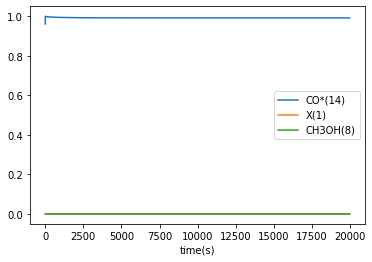

In [13]:
results.plot('time(s)',['CO*(14)', 'X(1)','CH3OH(8)'])
print(gas.X)


In [14]:
def save_flux_diagrams(*phases, suffix=''):
    """
    Saves the flux diagrams. The filenames have a suffix if provided,
    so you can keep them separate and not over-write.
    """
    for element in 'CHONX':
        for phase_object in phases:
            phase = phase_object.name

            diagram = ct.ReactionPathDiagram(phase_object, element)
            diagram.title = f'Reaction path diagram following {element} in {phase}'
            diagram.label_threshold = 0.01

            dot_file = f"reaction_path_{element}_{phase}{'_' if suffix else ''}{suffix}.dot"
            img_file = f"reaction_path_{element}_{phase}{'_' if suffix else ''}{suffix}.png"
            img_path = os.path.join(os.getcwd(), img_file)
            diagram.write_dot(dot_file)
            #print(diagram.get_data())

            print(f"Wrote graphviz input file to '{os.path.join(os.getcwd(), dot_file)}'.")
            os.system(f'dot {dot_file} -Tpng -o{img_file} -Gdpi=200')
            print(f"Wrote graphviz output file to '{img_path}'.")

def show_flux_diagrams(*phases, suffix='', embed=False):
    """
    Shows the flux diagrams in the notebook.
    Loads them from disk.
    Does not embed them, to keep the .ipynb file small,
    unless embed=True. Use embed=True if you might over-write the files,
    eg. you want to show flux at different points.
    """
    import IPython
    for element in 'CHONX':
        for phase_object in phases:
            phase = phase_object.name
            img_file = f"reaction_path_{element}_{phase}{'_' if suffix else ''}{suffix}.png"
            display(IPython.display.HTML(f'<hr><h2>{element} {phase}</h2>'))
            if embed:
                display(IPython.display.Image(filename=img_file,width=400,embed=True))
            else:
                display(IPython.display.Image(url=img_file,width=400,embed=False))

In [15]:
save_flux_diagrams(gas)

Wrote graphviz input file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/RMG_wDeut/reaction_path_C_gas.dot'.
Wrote graphviz output file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/RMG_wDeut/reaction_path_C_gas.png'.
Wrote graphviz input file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/RMG_wDeut/reaction_path_H_gas.dot'.
Wrote graphviz output file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/RMG_wDeut/reaction_path_H_gas.png'.
Wrote graphviz input file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/RMG_wDeut/reaction_path_O_gas.dot'.
Wrote graphviz output file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/RMG_wDeut/reaction_path_O_gas.png'.
Wrote graphviz input file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/RMG_wDeut/reaction_path_N_gas.dot'.
Wrote graphviz output file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/RMG_wDeut/reaction_path_N_gas.png'.
Wrot

In [16]:
save_flux_diagrams(surf)

Wrote graphviz input file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/RMG_wDeut/reaction_path_C_surface1.dot'.
Wrote graphviz output file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/RMG_wDeut/reaction_path_C_surface1.png'.
Wrote graphviz input file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/RMG_wDeut/reaction_path_H_surface1.dot'.
Wrote graphviz output file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/RMG_wDeut/reaction_path_H_surface1.png'.
Wrote graphviz input file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/RMG_wDeut/reaction_path_O_surface1.dot'.
Wrote graphviz output file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/RMG_wDeut/reaction_path_O_surface1.png'.
Wrote graphviz input file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/RMG_wDeut/reaction_path_N_surface1.dot'.
Wrote graphviz output file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/RMG_w

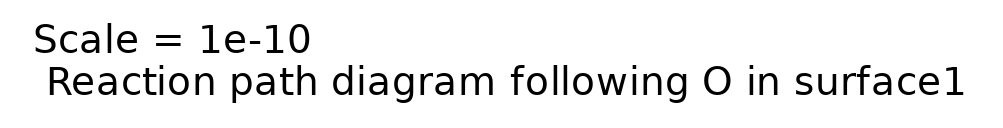

In [21]:
Image(filename='reaction_path_O_surface1.png')

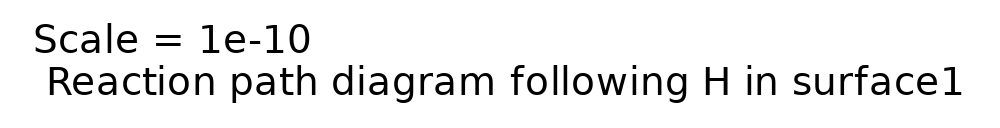

In [22]:
Image(filename='reaction_path_H_surface1.png')

In [ ]:
# Report the highest rates in reaction
def report_rates(n=8):
    print("\nHighest net rates of progress, gas")
    for i in np.argsort(abs(gas.net_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.net_rates_of_progress[i]:8.1g}")
    print("\nHighest net rates of progress, surface")
    for i in np.argsort(abs(surf.net_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {surf.reaction_equation(i):48s}  {surf.net_rates_of_progress[i]:8.1g}")
    print("\nHighest forward rates of progress, gas")
    for i in np.argsort(abs(gas.forward_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rates_of_progress[i]:8.1g}")
    print("\nHighest forward rates of progress, surface")
    for i in np.argsort(abs(surf.forward_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {surf.reaction_equation(i):48s}  {surf.forward_rates_of_progress[i]:8.1g}")
    print("\nHighest reverse rates of progress, gas")
    for i in np.argsort(abs(gas.reverse_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rates_of_progress[i]:8.1g}")
    print("\nHighest reverse rates of progress, surface")
    for i in np.argsort(abs(surf.reverse_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {surf.reaction_equation(i):48s}  {surf.reverse_rates_of_progress[i]:8.1g}")

report_rates()

In [ ]:
def report_rate_constants(n=8):
    print("\nHighest forward rate constants, gas")
    for i in np.argsort(abs(gas.forward_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rate_constants[i]:8.1e}")
    print("\nHighest forward rate constants, surface")
    for i in np.argsort(abs(surf.forward_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {surf.reaction_equation(i):48s}  {surf.forward_rate_constants[i]:8.1e}")
        print(surf.reaction(i).is_sticking_coefficient)
    print("\nHighest reverse rate constants, gas")
    for i in np.argsort(abs(gas.reverse_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rate_constants[i]:8.1e}")
    print("\nHighest reverse rate constants, surface")
    for i in np.argsort(abs(surf.reverse_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {surf.reaction_equation(i):48s}  {surf.reverse_rate_constants[i]:8.1e}")

    print("Units are a combination of kmol, m^3 and s, that depend on the rate expression for the reaction.")
report_rate_constants()

## Analysis of H2 and H2X thermo

In [ ]:
# Molar enthalpy
# species(self, k=None)
# species_index(self, species)
# species_name(self, k)
ThermoTemp = 483.5          # [kelvin]
pressure = 15.3*1e5         # [Pascals] 

for i in surf.species_names:
    if 'H2X' in i and ('C' not in i): 
#         print('Name: ', i , '  index:  ', surf.species_index(i))
        H2X_index = surf.species_index(i)
        H2X_name = i        
# print(H2X_index, '  ', H2X_name)

for i in gas.species_names:
    if 'H2(' in i and ('C' not in i): 
#         print('Name: ', i , '  index:  ', gas.species_index(i))
        H2_index = gas.species_index(i)
        H2_name = i        
# print(H2_index, '  ', H2_name)


H2X_H = surf.species(H2X_index).thermo.h(ThermoTemp)  # [J/kmol]
H2_H = gas.species(H2X_index).thermo.h(ThermoTemp)    # [J/kmol]

deltaH = H2_H - H2X_H   # [J/kmol]

deltaH = deltaH/10**6 # convert to [kJ/mol]

H2X_G = surf.standard_gibbs_RT[H2X_index]*8.3145*ThermoTemp # [J/mol]
H2_G = gas.standard_gibbs_RT[H2_index]*8.3145*ThermoTemp    # [J/mol]

deltaG = H2_G - H2X_G   # [J/mol]
deltaG = deltaG/10**3   # [kJ/mol]

print('Enthalpy: ',deltaH, '[kJ/mol]', '\nGibbs   : ', deltaG, ' [kJ/mol]')

### equilibration of H2 only

In [ ]:
# Grabow model and RMG input files
# cti_file_rmg = 'Grabow_species_removed/chem_annotated_removed.cti'
cti_file_rmg = 'chem_annotated.cti'

#constants
pi = math.pi

# set initial temps, pressures, concentrations
# temp = 230+273.15         # [kelvin]
temp = 483.5                # [kelvin]
pressure = 15.3*1e5         # [Pascals] 
X_co = 0.0
X_co2= 0.0
X_h2 = 1.0
mw_co = 28.01e-3     # [kg/mol]
mw_co2 = 44.01e-3    # [kg/mol]
mw_h2 = 1.01e-3      # [kg/mol]

# CO/CO2/H2/H2O: typical is 
concentrations_rmg = {'CO(3)': X_co,'CO2(4)': X_co2, 'H2(2)':X_h2}

# initialize cantera gas and surface
gas= ct.Solution(cti_file_rmg,'gas')

# surf_grab = ct.Interface(cti_file,'surface1_grab', [gas_grab])
surf = ct.Interface(cti_file_rmg,'surface1', [gas])

# gas_grab.TPX = 
gas.TPX = temp, pressure, concentrations_rmg
surf.TP = temp, pressure
surf.coverages = 'X(1):1.0'

# equilibrate surface
surf.equilibrate(XY='TP')